In [1]:
from cbayes import sample
from cbayes import distributions
from cbayes import solve
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
import scipy.stats as sstats
import ipywidgets as wid

In [2]:
plt.rcParams['font.size'] = 18

In [3]:
def make_model(skew):
    # this function makes a linear map whos first component is the x-unit vector
    # and each subsequent component is a norm-1 vector satisfying the property
    # that the 2-2 map made from it and the aforementioned unit vector is a map
    # with skewness in skew_range, which is a list of desired skewnesses   
    # TODO currently this map only works for 2-D input space     
    
    def my_model(parameter_samples):
        Q_map = skewmat(skew)
        QoI_samples = np.dot(parameter_samples, np.transpose(Q_map))
#         QoI_samples = Q_map@parameter_samples.T
        return QoI_samples
    return my_model

def skewmat(skew):
    Q_map = [ [1.0, 0.0] ] # all map components have the same norm, rect_size to have measures of events equal btwn spaces.
    Q_map.append( [np.sqrt(skew**2 - 1), 1] ) # taken with the first component, this leads to a 2-2 map with skewsness 's'
    Q_map = np.array( Q_map )
    return Q_map

def gauss_sol(prior_mean, prior_std, data_std, A, data):
    if type(prior_mean) is int:
        prior_mean = [prior_mean, prior_mean]
    if type(prior_mean) is float:
        prior_mean = [prior_mean, prior_mean]
    if type(prior_mean) is list:
        prior_mean = np.array(prior_mean).reshape(-1,1)
    if type(prior_std) is list:
        prior_std = np.array(prior_std).reshape(-1,1)
    if type(data_std) is list:
        data_std = np.array(data_std).reshapea(-1,1)
    prior_cov = prior_std*prior_std*np.eye(2) 
    data_cov = data_std*data_std*np.eye(2) 
    
    ASA = A@prior_cov@A.T
    
    precision = np.linalg.inv(ASA + data_cov)
    kahlman_update = (prior_cov@A.T@precision)
    post_mean = prior_mean + kahlman_update@(data - A@prior_mean)
    post_cov = prior_cov - kahlman_update@A@prior_cov
    
    return prior_mean, prior_cov, post_mean, post_cov

def id_model(input_samples):
    return input_samples[:,0].reshape(-1,1) - input_samples[:,1].reshape(-1,1)# lambda is first entry


In [4]:
def makemodel(t):
    def model(lam = np.array([[0.5, 0.0]]) ):
        QoI = lam[:,0].reshape(-1,1)*np.exp(-0.5*t) - lam[:,1].reshape(-1,1)
        if QoI.shape[0] == 1:
            return QoI.ravel() # this allows support for simpler 1D plotting.
        else:
            return QoI
    return model

##### FIXED PARAMETERS - DEFINE YOUR EXPERIMENT #####
num_observations = 10 # how many observations are you able to make?
start_time = 1
end_time = 5
####

t = np.linspace(start_time, end_time, num_observations)
ed_model = makemodel(t)
u = ed_model()

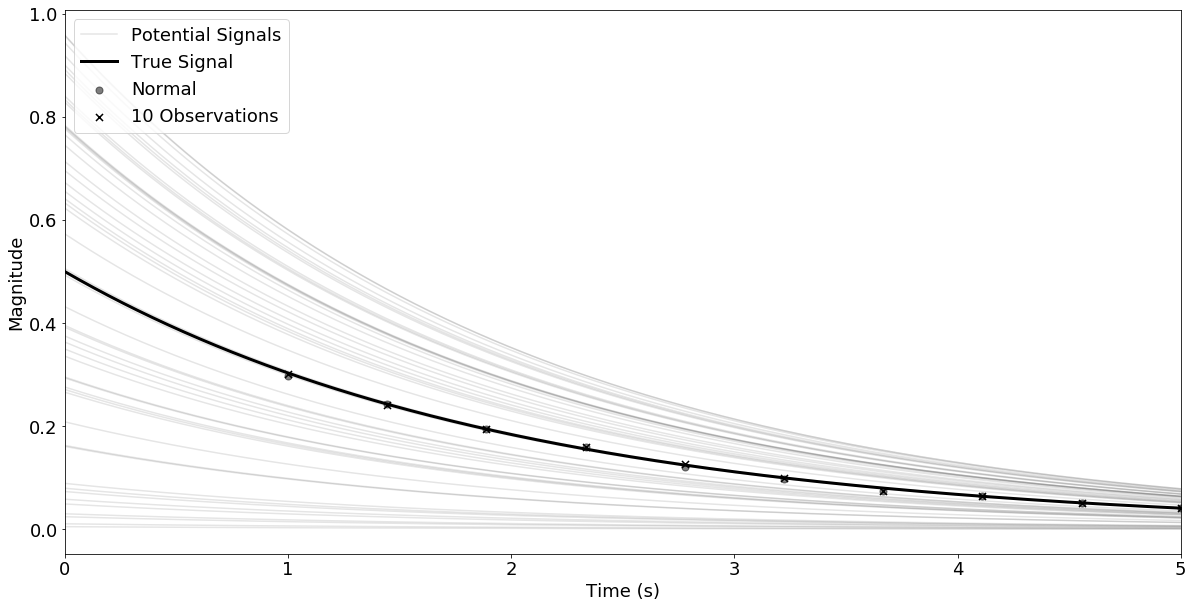

In [6]:
n = 50
lam = np.random.random(size=(n,2))
lam[:,1] = 0 # noise-free

sd_test_n = 0.0025
# sd_test_u = 0.05
mintime = 0
maxtime = 5
tt = np.linspace(mintime, maxtime, 1000)
m = makemodel(tt)
ui = m(lam)

um = m()
plt.figure(figsize=(20,10))
plt.cla()
show_obs = True
# Plotting the default IR results from the epidemic_IR function.
for i in range(n):
    d = ui[i,:]
    if i == n-1:
        plt.plot(tt, d, c='k', alpha=5/n, label='Potential Signals')
    else:
        plt.plot(tt, d, c='k', alpha=5/n) # I

plt.scatter(t, u + np.random.randn(num_observations)*sd_test_n, s=50, c='k', label='Normal', alpha=0.5)
# plt.scatter(t, u + (np.random.rand(num_observations)-0.5)*sd_test_u,c='b', s=5, label='Uniform')
# plt.scatter(t, u + (np.random.standard_cauchy(num_observations))*sd_test_c,c='g', s=50, marker='x',label='Cauchy')
plt.plot(tt, um, c='k', lw=3, ls='-', label='True Signal')
if show_obs:
    plt.scatter(t, u + np.random.randn(num_observations)*sd_test_n, marker='x', s=50, c='k', label='{} Observations'.format(num_observations), alpha=1)

plt.legend(fontsize=18,loc='upper left')
plt.ylabel('Magnitude', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)
# plt.ylim([-.25,1.25])
plt.xlim([0,5])
ftype = 'png'
if show_obs:
    summary_save_str = "saveimgs/HO/HO_%d_r-%d_obs-%de-3_sd-t_%d_%d_st%d_%d.%s"%(n, num_observations, 1000*sd_test_n, mintime, maxtime, start_time, end_time, ftype)
else:
    summary_save_str = "saveimgs/HO/HO_signal-%d_t_%d_%d_st%d_%d.%s"%(n, mintime, maxtime, start_time, end_time, ftype)

# print("saving " + summary_save_str)
# plt.savefig(summary_save_str)
plt.show()

noise: 0.055065793740182015
observed data: [[-0.25]]
ratio mean 1.0055282947601258
center: 0.055065793740182015
integral of conditional on noise: 1.7576308186243799 error: 1.595075614973173e-08


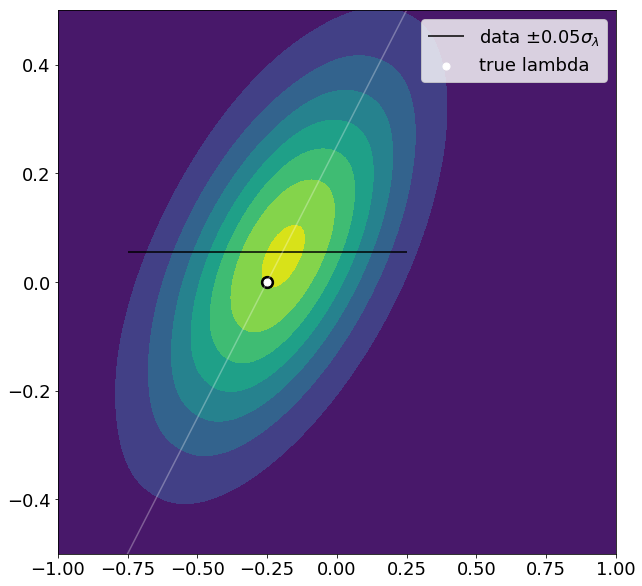

In [102]:
data_std = 0.25
prior_std = 0.5

N = 20000
M = 1

lam = -0.25
ns = 100
np.random.seed(227) #7146
noise = np.random.randn()*data_std
lam_true = np.array([lam, 0.0]).reshape(1,-1)
model = id_model
obs_data = model(lam_true) + 0*noise

center = noise # noise | obs_data | lam # FOR Y AXIS

initial_dist = sstats.distributions.norm(scale=[prior_std, data_std], loc=[0,0])
input_samples = initial_dist.rvs(size=(N,2))

print('noise:', noise)
print('observed data:', obs_data)

def loss_fun(output_samples):
#     return (1./M)*np.sum( np.power(np.divide(output_samples - obs_data, data_std), 2), axis=1)
#     return (1./np.sqrt(2*M))*np.sum( np.power(np.divide(output_samples - observed_data, data_std) , 2) - 1.0, axis=1)
    return (1./data_std)*(1./np.sqrt(M))*np.sum( output_samples - obs_data, axis=1)

output_samps = model(input_samples)
output_samples = loss_fun(output_samps)


# obs_dist = sstats.distributions.gamma(a=M/2.0, scale=2.0/M)
obs_dist = sstats.distributions.norm()

def pf_initial_dist_PDF(x):
    pf_dist = sstats.gaussian_kde(output_samples)
    return pf_dist.evaluate(x)
#     a, l, s = sstats.distributions.gamma.fit(output_samples,floc=0)
#     fit = sstats.distributions.gamma(a=a,loc=l,scale=s)
#     return fit.pdf(x)

pf_eval = pf_initial_dist_PDF(output_samples)
obs_eval = obs_dist.pdf(output_samples)

ratio = np.divide(obs_eval, pf_eval)

print('ratio mean', ratio.mean())


print('center:', center)
# eval_pts = np.zeros((ns,2))
# eval_pts[:,0] = obs_data[0]*.99999
eval_L = np.linspace(-2*prior_std, 2*prior_std, ns) 
eval_E = np.linspace(-2*data_std, 2*data_std, ns)
eval_pts = np.meshgrid(eval_L, eval_E)
eval_points = np.concatenate([eval_pts[0].ravel().reshape(-1,1), eval_pts[1].ravel().reshape(-1,1)],axis=1)
# eval_pts.reshape(ns,ns)
L = eval_pts[0].reshape(ns,ns)
E = eval_pts[1].reshape(ns,ns)


def eval_updated(x):
    y = loss_fun(model(x))
    return  np.product(initial_dist.pdf(x),axis=1)*np.divide(obs_dist.pdf(y), pf_initial_dist_PDF(y))
    
post_eval = eval_updated(eval_points).reshape(ns,ns)

# eval_points
plt.figure(figsize=(10,10))
plt.contourf(L,E,post_eval, vmin=0, vmax=None)
# plt.vlines(obs_data[0],-.5, .5,alpha=0.5)
# plt.vlines(0,-.5, .5,alpha=0.5)
plt.hlines(noise, -prior_std + obs_data, prior_std + obs_data, label='data $\pm 0.05\sigma_\lambda$')
plt.scatter([lam],[0*noise], color='black', s=150)
plt.scatter([lam],[0*noise], color='white', s=50, label='true lambda')
# plt.scatter(accepted_inputs[:,0], accepted_inputs[:,1])
plt.legend()

# plt.scatter(o[:,0], o[:,1])
plt.plot([-2*data_std+obs_data[0][0],2*data_std+obs_data[0][0]], [-2*data_std,2*data_std], 'white', alpha=0.3)
# plt.axis('equal')
# plt.savefig('ZZtestpost.png')]

def conditionalY(x, fixy = noise):
    return eval_updated(np.array([[x, fixy]]))

def conditionalX(y, fixx = lam):
    return eval_updated(np.array([[fixx, y]]))


I = quad(conditionalY, -1, 1, args=noise)
# I = quad(conditionalX, -2*data_std, 2*data_std, args=lam-1E-8)

print('integral of conditional on noise:', I[0], 'error:', I[1])
plt.show()

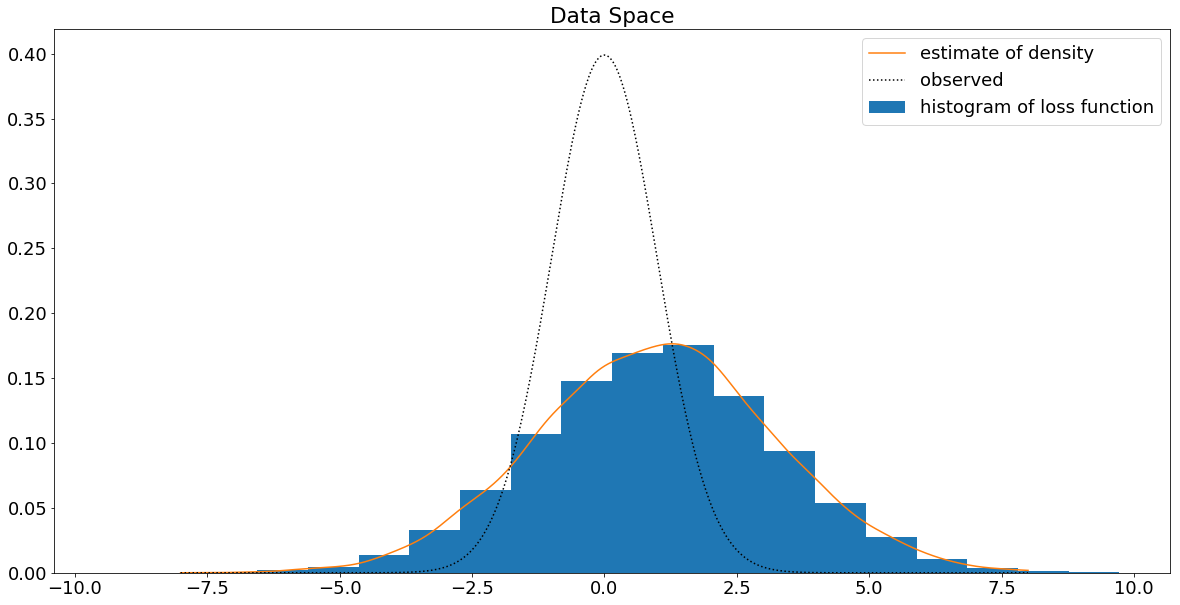

In [103]:
w = 8 # window size (to the left and right of zero)
plt.figure(figsize=(20,10))
plt.hist(output_samples, bins=20, density=True, label='histogram of loss function')
xmesh = np.linspace(-w, w, 1000)
plt.plot(xmesh, pf_initial_dist_PDF(xmesh), label='estimate of density')
plt.plot(xmesh, obs_dist.pdf(xmesh), 'k:', label='observed')
plt.title('Data Space')
plt.legend()
plt.show()

# Observed Noise

In [104]:
obs_data[0][0] + noise

-0.194934206259818

In [110]:
def noise_vary(eps, regularize=False):
    test_mesh = np.linspace(-1,1,500)
    I = quad(conditionalY, -1, 1, args=eps)[0]
    test_eval = np.array([conditionalY(xi, fixy=eps) for xi in test_mesh])
    plt.figure(figsize=(20,10))
    # plt.plot(test_mesh, sstats.norm(scale=data_std).pdf(test_mesh))
    plt.vlines(obs_data[0][0] + noise, 0, 2, label='$d$')
    plt.vlines(lam, 0, 2, color='blue', label='$\lambda_0$')
    plt.plot(test_mesh, test_eval/(1+regularize*(I-1)), c='r', label='conditional')
    plt.xlabel('$\lambda$')
    plt.ylim([0,3])
    plt.legend()
    plt.show()
    return I 
    
def lam_vary(lam0, regularize=False):
    test_mesh = np.linspace(-1,1,500)
    I = quad(conditionalX, -1, 1, args=lam0)[0]
    test_eval = np.array([conditionalX(xi, fixx=lam0) for xi in test_mesh])
    plt.figure(figsize=(20,10))
    plt.plot(test_mesh, sstats.norm(scale=data_std).pdf(test_mesh), label='N(0,$\sigma_d$)')
    plt.vlines(noise, 0, 2, label='noise')
    plt.vlines(0, 0, 2, color='blue', label='0')
    plt.plot(test_mesh, test_eval/(1+regularize*(I-1)), c='r', label='conditional')
    plt.xlabel('$\epsilon$')
    plt.ylim([0,3])
    plt.legend()
    plt.show()
    return I 

# Slice through a particular noise value.

In [111]:
wid.interact(noise_vary, eps=wid.FloatSlider(value=noise, min=-0.5, max=0.5, step=0.05),
            regularize=wid.Checkbox(value=True))

interactive(children=(FloatSlider(value=0.055065793740182015, description='eps', max=0.5, min=-0.5, step=0.05)…

<function __main__.noise_vary>

# Slice through a particular input parameter value.

In [113]:
wid.interact(lam_vary, lam0=wid.FloatSlider(value=lam, min=-0.5, max=0.5, step=0.05),
            regularize=wid.Checkbox(value=True))

interactive(children=(FloatSlider(value=-0.25, description='lam0', max=0.5, min=-0.5, step=0.05), Checkbox(val…

<function __main__.lam_vary>

In [ ]:
test_mesh = np.linspace(-1,1,500)
test_eval = [conditionalX(xi) for xi in test_mesh]
plt.plot(test_mesh, sstats.norm(scale=data_std).pdf(test_mesh))
plt.plot(test_mesh, test_eval)

In [ ]:
g = np.random.randn(5)

In [ ]:
c = np.cov(accepted_inputs.T)
m = np.mean(accepted_inputs, axis=0)
o = sstats.multivariate_normal(mean=m, cov=c).rvs(1000)


In [ ]:
# resolve pushforward
# joint - which marginals? which conditionals? project onto (1,1).. not interested
# conditionals on particular noise (horizontal cut)
#  p_set.evaluate_posterior(np.array([obs_data,0]).reshape(-1,1))[0] 
# plt.plot(obs_data)

In [41]:
# plt.contourf(L, E, post_eval)
post_eval.shape

(100, 100)

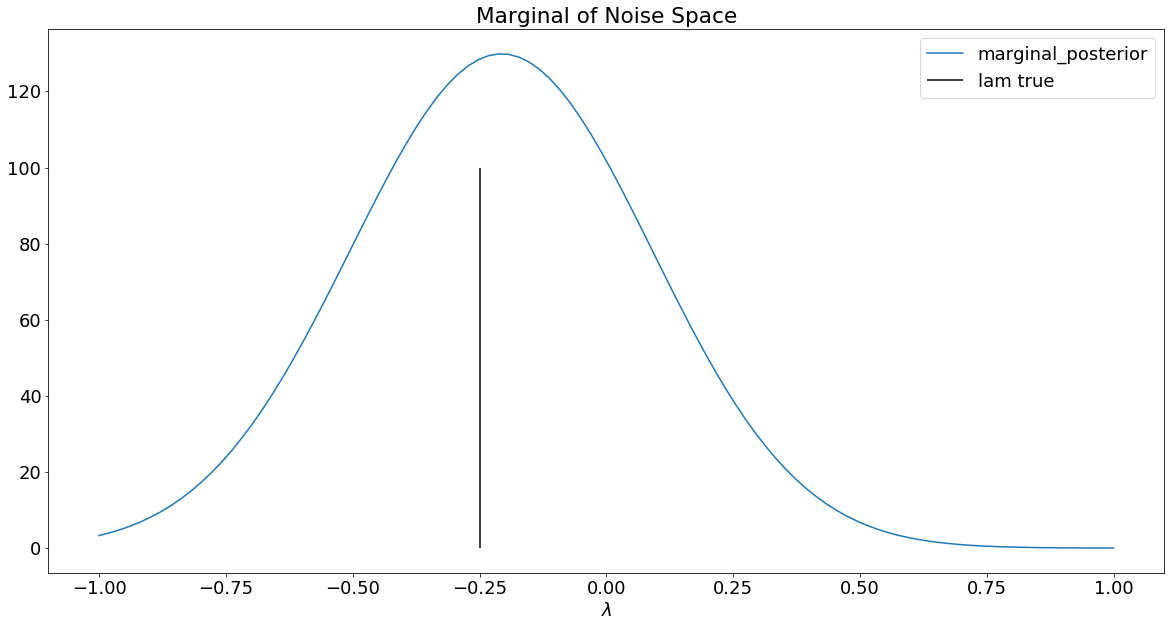

In [39]:
plt.figure(figsize=(20,10))
marg_L = np.sum(post_eval,axis=0)
plt.plot(eval_L.ravel(), marg_L, label='marginal_posterior')
plt.xlabel('$\lambda$')
plt.title('Marginal of Noise Space')
# plt.vlines(obs_data,0,100,'r', label='obs data')
plt.vlines(lam,0,100,'k', label='lam true')
# plt.ylim([0,1])
plt.legend()
plt.show()

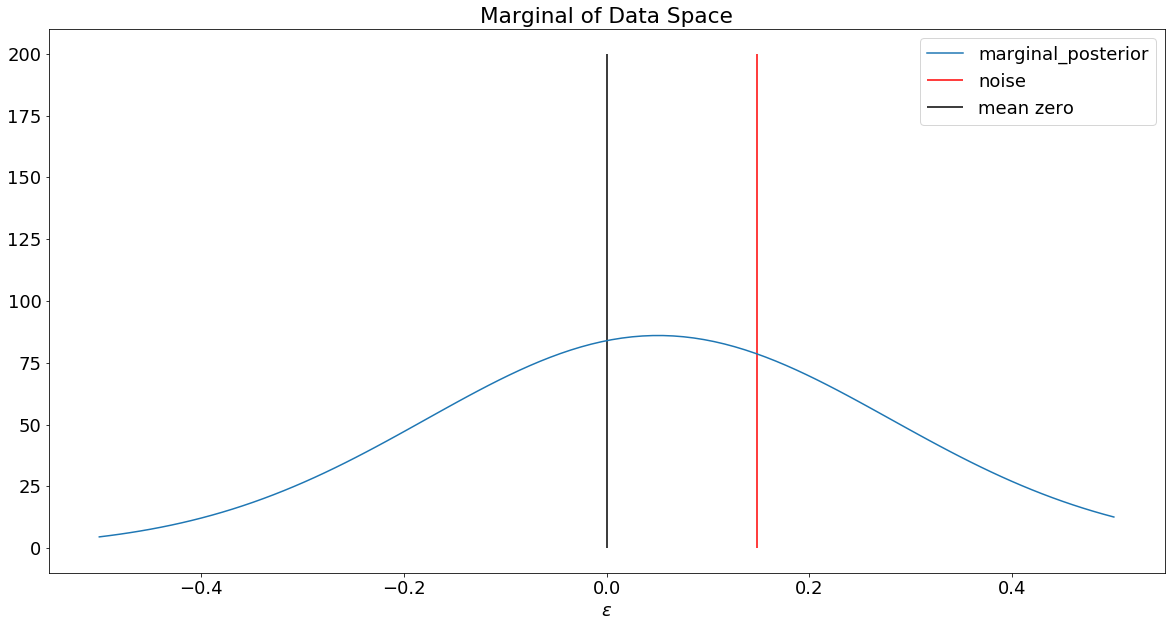

In [42]:
plt.figure(figsize=(20,10))
marg_E = np.sum(post_eval,axis=1)
marg_E = marg_E
plt.plot(eval_E.ravel(), marg_E, label='marginal_posterior')
# plt.plot(eval_E, sstats.distributions.norm.pdf(eval_E, loc=0,scale=data_std))
plt.xlabel('$\epsilon$')
plt.title('Marginal of Data Space')
plt.vlines(noise, 0, 200, 'r', label='noise')
plt.vlines(0, 0, 200, label='mean zero')
plt.legend()
plt.show()

# Old Code

In [ ]:
data_std = 0.25
prior_std = 0.5

N = 10000
M = 1

lam = -0.25
ns = 100
np.random.seed(2227) #7146
noise = np.random.randn()*data_std
lam_true = np.array([lam, 0.0]).reshape(1,-1)
model = id_model
obs_data = model(lam_true) + 0*noise

center = noise # noise | obs_data | lam # FOR Y AXIS

input_set = sample.sample_set((N,2))

input_set.set_dist(dim=0, dist='norm',kwds={'loc': 0, 'scale':prior_std})
input_set.set_dist(dim=1, dist='norm',kwds={'scale':data_std})
# input_samples = input_set.generate_samples()

input_samples = sstats.distributions.norm.rvs(size=(N,2),scale=[prior_std, data_std])
input_set.samples = input_samples

print('noise:', noise)
print('observed data:', obs_data)

mse = sample.MSE_generator(model, obs_data, data_std)
p_set = sample.map_samples_and_create_problem(input_set, mse)
p_set.set_observed_dist(dim=0, dist='gamma', kwds={'a': M/2.0, 'scale':2.0/M})


# qoi = id_model
# p_set = sample.map_samples_and_create_problem(input_set, qoi)
# p_set.set_observed_dist(dim=0, dist='norm', kwds={'loc': obs_data[0][0], 'scale':data_std})

a, l, s = sstats.distributions.gamma.fit(p_set.output.samples,floc=0)
fit = sstats.distributions.gamma(a=a,loc=l,scale=s)
# d, l, s = sstats.distributions.chi2.fit(p_set.output.samples)
# fit = sstats.distributions.chi2(df=d,loc=l,scale=s)

# p_set.output.dist = fit
p_set.pushforward_dist = fit
# p_set.compute_pushforward_dist(method='sk', kwds={'bandwidth': 0.05})
# p_set.compute_pushforward_dist(method='gk')
output_samples = p_set.output.samples

p_set.ratio = np.divide(p_set.observed_dist.pdf(output_samples).ravel(), p_set.pushforward_dist.pdf(output_samples).ravel() ).reshape(-1,1)

# p_set.set_ratio()
solve.problem(p_set)
acc = p_set.accept_inds
accepted_inputs = input_samples[acc,:]
print('ratio mean', p_set.ratio.mean())
# post = p_set.evaluate_posterior
# plt.figure(figsize=(10,10))
# plt.tricontourf(input_samples[:,0],input_samples[:,1], post)
# plt.xlim([-2*prior_std, 2*prior_std])
# plt.ylim([-2*data_std, 2*data_std])
# plt.vlines(obs_data[0],-.5, .5)
# plt.show()


print('center:', center)
# eval_pts = np.zeros((ns,2))
# eval_pts[:,0] = obs_data[0]*.99999
eval_L = np.linspace(-2*prior_std, 2*prior_std, ns) 
eval_E = np.linspace(-2*data_std, 2*data_std, ns)
eval_pts = np.meshgrid(eval_L, eval_E)
eval_points = np.concatenate([eval_pts[0].ravel().reshape(-1,1), eval_pts[1].ravel().reshape(-1,1)],axis=1)
# eval_pts.reshape(ns,ns)
L = eval_pts[0].reshape(ns,ns)
E = eval_pts[1].reshape(ns,ns)
post_eval = p_set.evaluate_posterior(eval_points).reshape(ns,ns)
# eval_points
plt.figure(figsize=(10,10))
plt.contourf(L,E,post_eval, vmin=0, vmax=None)
# plt.vlines(obs_data[0],-.5, .5,alpha=0.5)
# plt.vlines(0,-.5, .5,alpha=0.5)
plt.hlines(noise, -prior_std + obs_data, prior_std + obs_data, label='data $\pm 0.05\sigma_\lambda$')
plt.scatter([lam],[0*noise], color='black', s=150)
plt.scatter([lam],[0*noise], color='white', s=50, label='true lambda')
# plt.scatter(accepted_inputs[:,0], accepted_inputs[:,1])
plt.legend()
# plt.scatter(o[:,0], o[:,1])
plt.plot([-2*data_std+obs_data[0][0],2*data_std+obs_data[0][0]], [-2*data_std,2*data_std], 'white', alpha=0.3)
# plt.axis('equal')
# plt.savefig('ZZtestpost.png')
def conditionalY(x, fixy = noise):
    return p_set.evaluate_posterior(np.array([[x, fixy]]))[0]

def conditionalX(y, fixx = lam):
    return p_set.evaluate_posterior(np.array([[fixx, y]]))[0]


# I = quad(conditionalY, 2*prior_std, 2*prior_std, args=noise)
# I = quad(conditionalX, -2*data_std, 2*data_std, args=lam-1E-8)

# print('integral of conditional on noise:', I[0], 'error:', I[1])
plt.show()